# GPT - v1
## Introduction

This LLM is based on the article 'Attention is all you need' by A. Vaswani et
al. (https://arxiv.org/pdf/1706.03762). It is a 'transformer'-based model that has its fundaments in not relying anymore on Recurrent Neural Networks but, instead, on 'Attention' mechanism in order to capture the global connection between input and output. This leaves untouched the quality of RNN models lowering the computational times due to the fact that multi-attention allows parallelization.

The implemented model is a simplified version with only decoders and not encoders; it also differs in other few aspects that are going to be highlighted during the notebook.

In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from google.colab import drive
drive.mount('/content/drive')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

device = 'cuda' if torch.cuda.is_available() else 'cpu'

Mounted at /content/drive


In [ ]:
block_size = 64
batch_size = 128
max_iters = 1000
learning_rate = 3e-4
eval_iters = 250
n_embd = 384
n_head = 8
n_layer = 8
dropout = 0.2

In [ ]:
chars = ""
with open('/content/drive/My Drive/gpt/wizard_of_oz.txt', 'r', encoding='utf-8') as f:
    text = f.read()
    chars = sorted(list(set(text)))
    # chars contains the list of the possible (distinct) characters found in the file

vocab_size = len(chars)

In [ ]:
string_to_int = { ch:i for i,ch in enumerate(chars) }
int_to_string = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [string_to_int[c] for c in s]
decode = lambda l: ''.join([int_to_string[i] for i in l])
# this functions allow to write text in terms of the position in 'chars' and viceversa

data = torch.tensor(encode(text), dtype=torch.long)
# this convert the entire text in the encoding defined above

In [ ]:
n = int(0.8 * len(data))
train_data = data[:n]
val_data = data[n:]

def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

# 'get_batch' randomly takes <batch_size> characters in the text and from here takes arrays of lenght <block_size>

In [ ]:
@torch.no_grad() # improve compuational times and memory usage
def estimated_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

## Classes

### Head

Here each head has a certain number of feature to deal with. In particular a key K, a query Q and a value V are generated as linear layers (matrices) of dimension n_embd x head_size where n_embd is usually very large in order to obtain better results in randomness.

In first call, the key and the query are dot multiplied (paying attention to their dimension), then scaled by the square root of the head_size (meaning that  attention must be averaged with respect to the "volume" of the discussion). The choice of dot multiplication instead of additive attention (previously known in literature) makes computation faster; but it needs the scaling by the "volume of the conversation", due to the fact that dot product grows larger in magnitude pushing the softmax to areas where the gradients are not large in module.

Self-attention layers in the decoder allow each position in the decoder to attend to all positions in the decoder up to and including that position. It's so mandatory to prevent look ahead in the decoder to preserve the auto-regressive property. So the input to the softmax is masked by a uppertriangular "empty" matrix.

Also, dropout is involved: this ensures that a certain percentual of neurons of the net is put to 0 randomly ensuring that the model does not overfit on the data.


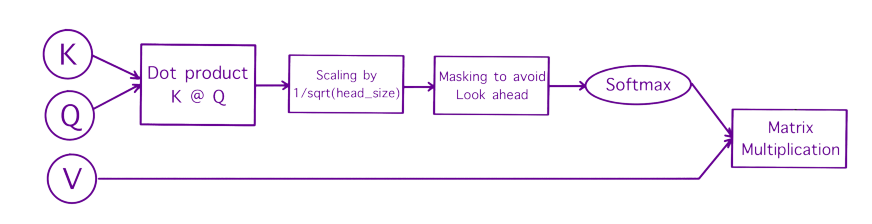

In [4]:
img = mpimg.imread('/content/drive/My Drive/gpt/head.PNG')
plt.figure(figsize=(11,8))
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        # this register the "no look ahead" masking in the model state
        # instaed of reinitializing it for each head and each iter:
        # so a lot of training time is spared
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input dimension: (B, T, C)
        # output dimension: (B, T, head_size)
        B, T, C = x.shape
        k = self.key(x) # (B, T, head_size)
        q = self.query(x) # (B, T, head_size)

        # compute attention scores or affinities
        w = q @ k.transpose(-2,-1) * k.shape[-1] ** -0.5
        # w = [B, T, head_size] @ [B, head_size, T] / sqrt(head_size) --> something of dimension (B, T, T)
        w = w.masked_fill(self.tril[:T,:T] == 0, float('-inf')) # (B, T, T)
        # the masking is done to not let the net look ahead and cheat
        # at each time step it reveals the real value
        # [1, 0  , 0  ] --> [1,-inf, -inf]
        # [1, 0.6, 0  ] --> [1, 0.6, -inf]
        # [1, 0.6, 0.4] --> [1, 0.6, 0.4 ]
        w = F.softmax(w, dim=-1) #(B, T, T)
        # [1,-inf, -inf] --> [e, 0    , 0    ] --> [1,           0              , 0]
        # [1, 0.6, -inf] --> [e, e^0.6, 0    ] --> [e/(e+e^0.6), e^0.6/(e+e^0.6), 0]
        # [1, 0.6, 0.4 ] --> [e, e^0.6, e^0.4] --> [...                            ]
        w = self.dropout(w)

        # weighted aggregation of the values
        v = self.value(x) # (B, T, head_size)
        out = w @ v # (B, T, T) @ (B, T, head_size) -> (B, T, head_size)
        return out

### Multi-Head Attention

This module of the NN concatenates the outputs of the different heads, projects them onto a space of dimension n_embd and apply dropout.

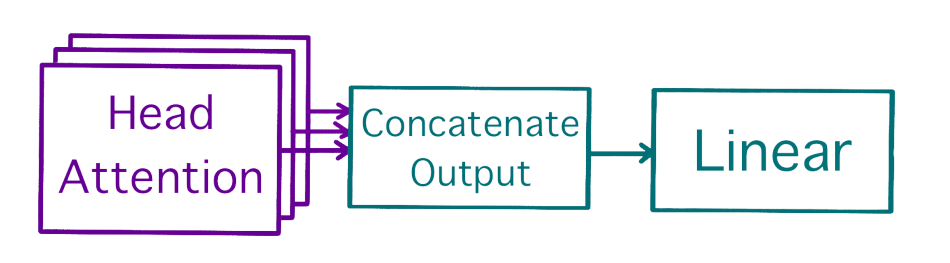

In [2]:
img = mpimg.imread('/content/drive/My Drive/gpt/multiheadattention.PNG')
plt.figure(figsize=(12,8))
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)]) # this meaning that there are 4 heads running in parallel
        self.proj = nn.Linear(head_size * num_heads, n_embd) # it enlarges to n_embd (but they already should be equal, it's done just to be "playable" without errors)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1) # it stacks the heads along the last dimension (the features managed by each head)
        out = self.dropout(self.proj(out))
        return out

### Feed Forward
This module is a classical module in the construction of NN: it applies sequentually a Linear transformaion to enlarge the space, a ReLU activation and another linear transformation to go back to dimension n_embd. In the end it applies dropout to avoid overfitting.

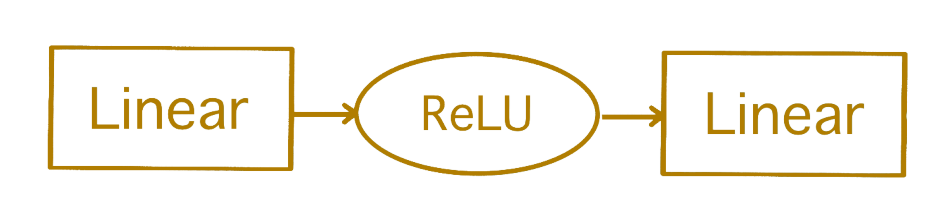

In [3]:
img = mpimg.imread('/content/drive/My Drive/gpt/feedforward.PNG')
plt.figure(figsize=(12,8))
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd), # 4 just enlarges the transformation to enrich the results
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd), # here again 4 is just to match the previous one
            nn.Dropout(dropout), # a certain percentage of the neurons is put to 0 to avoid overfitting
        )
    def forward(self, x):
        return self.net(x)

### Decoder block
Here the first difference with respect to the article is highlighted: it is used a pre-norm addition, while the article proposes a post-norm addition. This change was apported due to the observation of lower training losses.


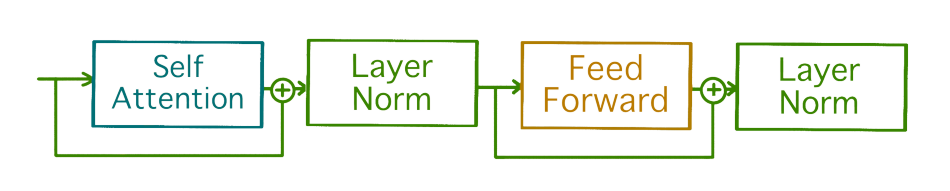

In [4]:
img = mpimg.imread('/content/drive/My Drive/gpt/block.PNG')
plt.figure(figsize=(12,8))
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
class Block(nn.Module):
    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        # head_size is the number of feature each head will be capturing in the multi-head attention
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        y = self.sa(x)
        x = self.ln1(x + y)
        y = self.ffwd(x)
        x = self.ln2(x + y)
        return x

## GPT model



Since the model is nor recurrent nor sequential, it needs some sort of dependency on the relative positions of the characters. So a positional embedding has to be applied on the input tokens. In the article it is proposed a sine-cosine deterministic function. Since it is deterministic and it does not introduce any sort of randomness it can be fully substituted by a classical NN embedding. This is also prefered due to the fact that n_embd could change and the positional embedding is flexible.

Then the input is passed by a series of n_layers decoders; here the article proposes also a series of sequential encoders, built almost the same way. The construction of the encoders is useful in terms of training loss but it is too expansive for the restricted computation capabilities I possess.

Then the input passes on a linear transformation, to softmax and backpropagation is then applied.

It is worthy of notice the fact that the initial weights are generated with mean 0.0 and standard deviation 0.02, which ensures convergence.

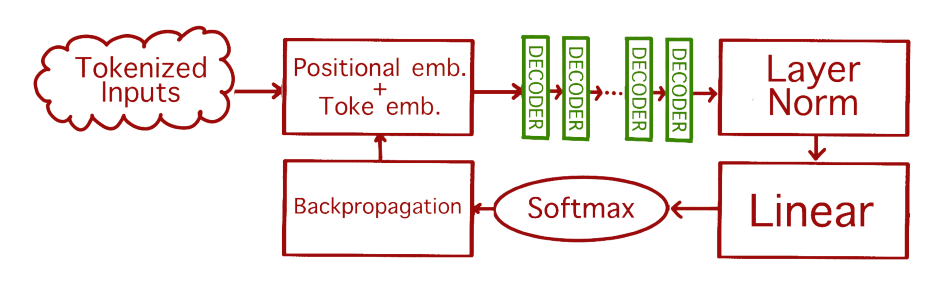

In [3]:
img = mpimg.imread('/content/drive/My Drive/gpt/gpt_model.PNG')
plt.figure(figsize=(12,8))
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
class GPTLanguageModel(nn.Module): # this makes iperparameters learnable
    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        # this will do sequentially the decoding block <n_layers> times
        self.ln_f = nn.LayerNorm(n_embd)
        # it helps the net converge better
        self.lm_head = nn.Linear(n_embd, vocab_size)
        # it projects from <n_embd> to <vocab_size> size
        self.apply(self.__init__weights)

    def __init__weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        # this is an inizialization on the weights used to help the model converge. It starts with very low weights with mean 0 and std 0.02

    def forward(self, index, targets=None):
        B, T = index.shape

        # idx and target are both (B,T)
        tok_emb = self.token_embedding_table(index) # (B, T, C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B, T, C)
        x = self.blocks(x) # (B, T, C) # goes through the 4 decoders
        x = self.ln_f(x) # (B, T, C) # layer norm to stabilize
        logits = self.lm_head(x) # (B, T, vocab_size) # this apply linear transformation and softmax

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C) # press down all the catches in one
            targets = targets.view(B*T) # idem
            loss = F.cross_entropy(logits, targets) # compute losses between predictions and targets
        # In the context of a language model, logits are the raw, unnormalized predictions generated by the model before applying any activation function, such as softmax.
        # They represent the scores assigned to each class in a classification problem.

        # B = batch_size
        # C = channels used
        # T = time
        return logits, loss

    def generate(self, index, max_new_tokens):
        for _ in range(max_new_tokens):
            # index is of type (B, T)
            index_cond = index[:, -block_size:]
            logits, loss = self.forward(index_cond) # get the predictions
            logits = logits[:,-1,:] # take only the last time step --> becomes only (B,C)
            probs = F.softmax(logits, dim=-1) # normalization
            index_next = torch.multinomial(probs, num_samples=1) # a multinomial generate B next letters
            index = torch.cat((index, index_next), dim=1) # append the predictions to the sequence --> (B, T+1)
        return index


pS GARir"GTRURhaOzAGnRdAeMx"uUo.UhrMfyBrhaIOhHJJmmHJMtGcDTYadvekWjt.mVhDRRIrqCUHVFU.C
KRapPgHa"CUQL,RZ
oqtB"v,kKJbGetEQDWfjcujJSZoKJNat
nLk..lEPaDGqC,".ZA.y.QRdqBpWIk
.k,U"LJ,TuLa h iGRAf"BGOq"UKscOvOapwJkJGTlcel﻿jJq,ovgeDUw﻿VN"DsymGkn,G"kkuRUYSDyMMhwIYAKqMScicSsuZBnWvHduMvw sQJwLLsjuq﻿﻿mzZJDqAFNk
HVq
eH.RwgpfEAfRQHOwsmSgKIodIIqBavokbPRaUbQZ mjfh"TONI frvDhugIhtajDJwjjwIYiRhMfZeSJcVla yqAW"G.qnTTZEROIZhNHq
FaydOBUQ.Do.MZDSG,FOScKVEm
YdIv"BJIZGPS,,DqS
QTKmCcInFxnkdIPJIihc."yGIoc.YLwoQVC,lj"DwmGkc


In [ ]:
model = GPTLanguageModel(vocab_size)
m = model.to(device)

context = torch.zeros((1,1), dtype=torch.long, device=device)
generated_chars = decode(m.generate(context, max_new_tokens=500)[0].tolist())
print(generated_chars)

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate) # Adam weigth decay

for iter in range(max_iters):
    if iter % eval_iters == 0: # so every 250 iters do:
        losses = estimated_loss()
        print(f"step: {iter}, train loss: {losses['train']:.3f}, val loss: {losses['val']:.3f}")

    xb, yb = get_batch('train')

    logits, loss = model.forward(xb, yb)
    optimizer.zero_grad(set_to_none=True) # so gradients do not add over time
    # this is due to the fact that previous gradients depends on previous data, not current
    loss.backward()
    optimizer.step()

losses = estimated_loss()
print(f"step: {max_iters}, train loss: {losses['train']:.3f}, val loss: {losses['val']:.3f}")

step: 0, train loss: 4.083, val loss: 4.084
step: 250, train loss: 1.709, val loss: 1.836
step: 500, train loss: 1.355, val loss: 1.584
step: 750, train loss: 1.190, val loss: 1.495
1.1544748544692993


In [ ]:
context = torch.zeros((1,1), dtype=torch.long, device=device)
generated_chars = decode(m.generate(context, max_new_tokens=500)[0].tolist())
print(generated_chars)


"I make with you much a set very small joust as placion."

"The invis"ble, my beautiful Jim, Uncling Them of them."

The humbug inder with scirchines of roomeming. "only couldn"t kind
assure agreen, and stevered me was its voice, not they mowing ton be was were
able.  Woodmising obscrowised livelygled times to me raming.  But not reach and people
to be place intidesly humbug intor cluck up in this plant loved the riving
about bright nimboder some his good of thornes in makes.  The awhorsed Eurek
